In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report  
import gradio as gr  
from PIL import Image

In [ ]:
img_size=(128,128)
batch_size=32
validation_split=False

In [21]:
#path
train_dir=r"C:\Users\HP\OneDrive\Documents\Desktop\InternShip\modified-dataset\train"
val_dir=r"C:\Users\HP\OneDrive\Documents\Desktop\InternShip\modified-dataset\val"
test_dir=r"C:\Users\HP\OneDrive\Documents\Desktop\InternShip\modified-dataset\test"



In [ ]:
#loading the dataset
datatrain= tf.keras.utils.image_dataset_from_directory(train_dir,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [24]:
datatest=tf.keras.utils.image_dataset_from_directory(test_dir,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [25]:
datavalid = tf.keras.utils.image_dataset_from_directory(val_dir,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [29]:
print(len(datatrain.class_names))
class_names=datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


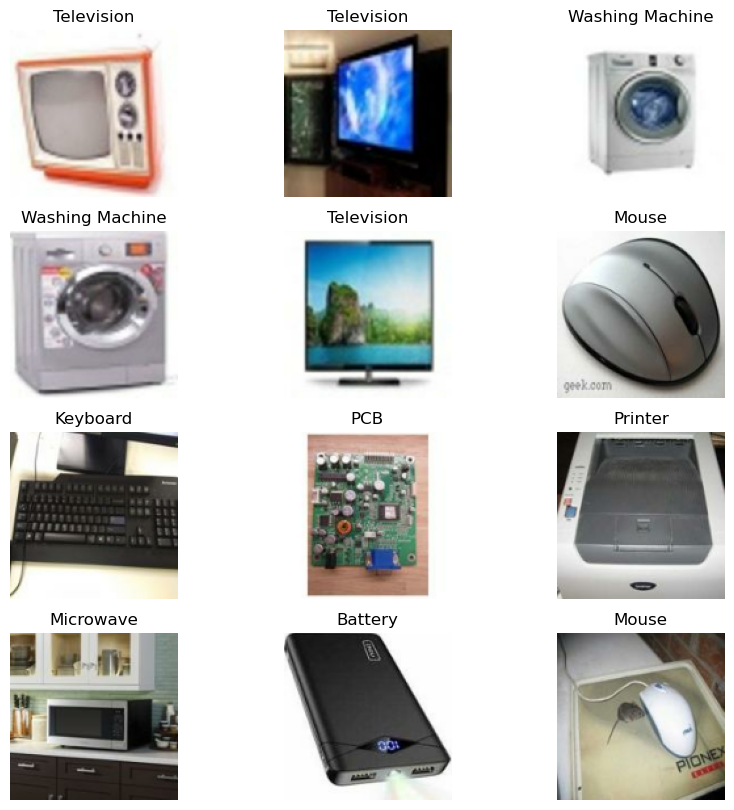

In [30]:
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")